In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

import torchvision.datasets

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

___

In [2]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [4]:
len(y_train), len(y_test)

(50000, 10000)

In [5]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [6]:
X_train /= 255.
X_test /= 255.

In [7]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

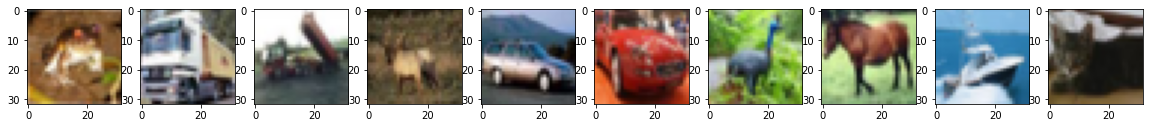

In [8]:
plt.figure(figsize=(20,2))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])

    print(y_train[i], end=' ')

In [9]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [10]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [11]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [12]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [13]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    
    del net
    
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.3876)
tensor(0.4334)
tensor(0.4709)
tensor(0.4962)
tensor(0.4969)
tensor(0.5182)
tensor(0.5263)
tensor(0.5363)
tensor(0.5425)
tensor(0.5401)
tensor(0.5462)
tensor(0.5455)
tensor(0.5432)
tensor(0.5542)
tensor(0.5565)
tensor(0.5588)
tensor(0.5550)
tensor(0.5537)
tensor(0.5534)
tensor(0.5523)
tensor(0.5545)
tensor(0.5500)
tensor(0.5449)
tensor(0.5490)
tensor(0.5471)
tensor(0.5472)
tensor(0.5427)
tensor(0.5429)
tensor(0.5394)
tensor(0.5422)
tensor(0.4301)
tensor(0.4809)
tensor(0.4851)
tensor(0.5200)
tensor(0.5282)
tensor(0.5442)
tensor(0.5598)
tensor(0.5637)
tensor(0.5792)
tensor(0.5851)
tensor(0.5860)
tensor(0.5854)
tensor(0.5971)
tensor(0.6079)
tensor(0.6004)
tensor(0.6015)
tensor(0.5946)
tensor(0.6077)
tensor(0.6117)
tensor(0.6057)
tensor(0.6132)
tensor(0.6167)
tensor(0.6209)
tensor(0.6201)
tensor(0.6170)
tensor(0.6266)
tensor(0.6209)
tensor(0.6185)
tensor(0.6220)
tensor(0.6251)
tensor(0.3745)
tensor(0.4513)
tensor(0.4950)
tensor(0.5170)
tensor(0.5246)
tensor(0.5428)
tensor(0.5

/home/folley/.pyenv/versions/3.7.9/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.4112)
tensor(0.4847)
tensor(0.5229)
tensor(0.5415)
tensor(0.5702)
tensor(0.5770)
tensor(0.5853)
tensor(0.6003)
tensor(0.6029)
tensor(0.6198)
tensor(0.6245)
tensor(0.6264)
tensor(0.6351)
tensor(0.6373)
tensor(0.6381)
tensor(0.6419)
tensor(0.6516)
tensor(0.6367)
tensor(0.6519)
tensor(0.6431)
tensor(0.6430)
tensor(0.6477)
tensor(0.6491)
tensor(0.6494)
tensor(0.6515)
tensor(0.6481)
tensor(0.6512)
tensor(0.6462)
tensor(0.6476)
tensor(0.6368)
tensor(0.5412)
tensor(0.5898)
tensor(0.6058)
tensor(0.6389)
tensor(0.6458)
tensor(0.6385)
tensor(0.6597)
tensor(0.6640)
tensor(0.6582)
tensor(0.6623)
tensor(0.6526)
tensor(0.6542)
tensor(0.6565)
tensor(0.6524)
tensor(0.6597)
tensor(0.6524)
tensor(0.6519)
tensor(0.6428)
tensor(0.6364)
tensor(0.6462)
tensor(0.6381)
tensor(0.6324)
tensor(0.6400)
tensor(0.6414)
tensor(0.6305)
tensor(0.6357)
tensor(0.6367)
tensor(0.6453)
tensor(0.6332)
tensor(0.6343)


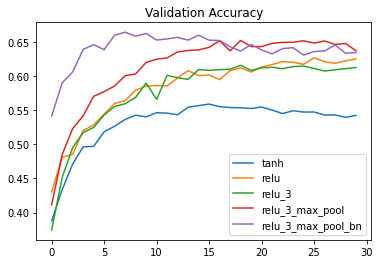

In [14]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)

plt.legend()
plt.title('Validation Accuracy')

plt.show()

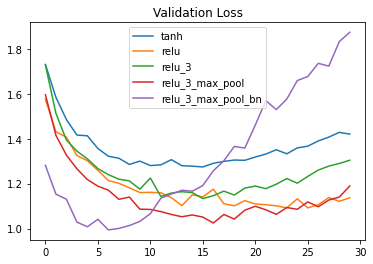

In [15]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)

plt.legend()
plt.title('Validation Loss')

plt.show()